<a href="https://colab.research.google.com/github/marziye-jalili/deep_learning/blob/main/Copy_of_classification_DenseNet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. [**Importing Libraries and Setting Up Environment**](#importing-libraries-and-setting-up-environment)



---


#⚡ 1. **Importing Libraries and Setting Up Environment**



---



In [ ]:
# Standard libraries
import os
import shutil
import random
import math

# Numerical and data manipulation libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import resample

# Image processing libraries
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and evaluation libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and Keras libraries for deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, UpSampling2D, concatenate, Multiply
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Google Colab and PyDrive libraries
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

## Importing Libraries and Setting Up Environment
![](https://drive.google.com/uc?id=1d_hWZrTegkketwuFm76Nm7BtYLDV9_w5)

---

#⚡ 2. **Downloading and Extracting the Dataset**

---



In [ ]:
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# TC-dataset
file_id_best_weights = '1r8b9xM-Wb1Zb8dhZORX_zmaJ-UwYgumH'
downloaded_weights = drive.CreateFile({'id': file_id_best_weights})
downloaded_weights.GetContentFile('TN.dataset.zip')

print("Files downloaded successfully!")

Files downloaded successfully!


In [ ]:
import zipfile
# extraction of data from zipfiles to data folder
extract_path = '/content/TN.dataset'
zip_file_path = '/content/TN.dataset.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print('Test1 Extraction is completed\n')

Test1 Extraction is completed



#⚡ 3. **Loading Data**

In [ ]:
# Path to the CSV files
csv_paths = {
    'Asemptomatik Grade 0': r'/content/TN.dataset/regions_interpolate_edit2/1_Asemptomatik Grade 0/Asemptomatik Grade 0.csv',
    'Asemptomatik Grade 1': r'/content/TN.dataset/regions_interpolate_edit2/2_Asemptomatik Grade 1/Asemptomatik Grade 1.csv',
    'Semptomatik Grade 1': r'/content/TN.dataset/regions_interpolate_edit2/3_Semptomatik Grade 1/Semptomatik Grade 1.csv'
}

# Path to the dicom and ROI folders
image_paths = {
    'Asemptomatik Grade 0': r'/content/TN.dataset/regions_interpolate_edit2/1_Asemptomatik Grade 0/image',
    'Asemptomatik Grade 1': r'/content/TN.dataset/regions_interpolate_edit2/2_Asemptomatik Grade 1/image',
    'Semptomatik Grade 1': r'/content/TN.dataset/regions_interpolate_edit2/3_Semptomatik Grade 1/image'
}

roi_paths = {
    'Asemptomatik Grade 0': r'/content/TN.dataset/regions_interpolate_edit2/1_Asemptomatik Grade 0/roi',
    'Asemptomatik Grade 1': r'/content/TN.dataset/regions_interpolate_edit2/2_Asemptomatik Grade 1/roi',
    'Semptomatik Grade 1': r'/content/TN.dataset/regions_interpolate_edit2/3_Semptomatik Grade 1/roi'
}

#⚡ 4. **Splitting Dataset into Train, Validation, and Test Sets**

In [ ]:
# Function to load data from CSV and split based on patient_name
def load_and_split_data(csv_path):
    df = pd.read_csv(csv_path)

    # Extract unique patients
    patients = df['patient_name'].unique()

    # Split patients into training (70%), validation (10%), and test (20%)
    patients_train, patients_temp = train_test_split(patients, test_size=0.3, random_state=42)
    patients_val, patients_test = train_test_split(patients_temp, test_size=2/3, random_state=42)

    # Create DataFrame for each split
    df_train = df[df['patient_name'].isin(patients_train)]
    df_val = df[df['patient_name'].isin(patients_val)]
    df_test = df[df['patient_name'].isin(patients_test)]

    return df_train, df_val, df_test


#⚡ 5. **Creating Directory Structure for Data**

In [ ]:
# Function to create directories
def create_dirs(base_dir, classes):
    for split in ['train', 'val', 'test']:
        for cls in classes:
            os.makedirs(os.path.join(base_dir, split, 'images', cls), exist_ok=True)
            os.makedirs(os.path.join(base_dir, split, 'rois', cls), exist_ok=True)

# Function to save images and ROIs into class subfolders
def save_images_and_rois(df, image_dir, roi_dir, save_dir, split, class_name):
    for index, row in df.iterrows():
        image_name = row['image_name']

        # Source path of image and ROI
        image_source = os.path.join(image_dir, image_name)
        roi_source = os.path.join(roi_dir, image_name)

        # Destination path for image and ROI in class subfolder
        image_dest = os.path.join(save_dir, split, 'images', class_name, image_name)
        roi_dest = os.path.join(save_dir, split, 'rois', class_name, image_name)

        if os.path.exists(image_source):
            shutil.copy(image_source, image_dest)
        if os.path.exists(roi_source):
            shutil.copy(roi_source, roi_dest)

# Base directory for saving split data
save_dir = '/content/TN_dataset_split'

# List of classes
classes = list(csv_paths.keys())

# Create directories
create_dirs(save_dir, classes)

# Main loop for each class
for grade in csv_paths.keys():
    # Load and split data for this class
    df_train, df_val, df_test = load_and_split_data(csv_paths[grade])

    # Save images and ROIs for each split into the corresponding class subfolder
    save_images_and_rois(df_train, image_paths[grade], roi_paths[grade], save_dir, 'train', grade)
    save_images_and_rois(df_val, image_paths[grade], roi_paths[grade], save_dir, 'val', grade)
    save_images_and_rois(df_test, image_paths[grade], roi_paths[grade], save_dir, 'test', grade)

# Data has been split and saved
print("Dataset split and saved successfully!")


Dataset split and saved successfully!


#⚡ 6. **Zipping the Prepared Dataset (Optional)**

In [ ]:

folder_to_zip = '/content/TN_dataset_split'

output_filename = 'TN_dataset_split.zip'


shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)

'/content/TN_dataset_split.zip'

#⚡ 7. **Counting Samples in Each Class**

In [ ]:
# Define a base directory
base_dir = '/content/TN_dataset_split'


# Construct paths for train, val, and test splits
train_image_dirs = {
    'Asemptomatik Grade 0': os.path.join(base_dir, 'train', 'images', 'Asemptomatik Grade 0'),
    'Asemptomatik Grade 1': os.path.join(base_dir, 'train', 'images', 'Asemptomatik Grade 1'),
    'Semptomatik Grade 1': os.path.join(base_dir, 'train', 'images', 'Semptomatik Grade 1')
}

val_image_dirs = {
    'Asemptomatik Grade 0': os.path.join(base_dir, 'val', 'images', 'Asemptomatik Grade 0'),
    'Asemptomatik Grade 1': os.path.join(base_dir, 'val', 'images', 'Asemptomatik Grade 1'),
    'Semptomatik Grade 1': os.path.join(base_dir, 'val', 'images', 'Semptomatik Grade 1')
}

test_image_dirs = {
    'Asemptomatik Grade 0': os.path.join(base_dir, 'test', 'images', 'Asemptomatik Grade 0'),
    'Asemptomatik Grade 1': os.path.join(base_dir, 'test', 'images', 'Asemptomatik Grade 1'),
    'Semptomatik Grade 1': os.path.join(base_dir, 'test', 'images', 'Semptomatik Grade 1')
}


In [ ]:
# Function to count samples in each class for images
def count_samples_per_class(image_dirs):
    total_images = 0

    # Sum total images
    for grade in image_dirs.keys():
        image_dir = image_dirs[grade]

        # Count the number of images in each directory
        num_images = len(os.listdir(image_dir))
        total_images += num_images

    # Print the total count of images
    print(f"Total Images: {total_images}")

    # Print the detailed count of images for each class
    for grade in image_dirs.keys():
        image_dir = image_dirs[grade]

        num_images = len(os.listdir(image_dir))
        print(f"{grade} - Images: {num_images}")

# Count samples in the training set
print("Training set sample counts:")
count_samples_per_class(train_image_dirs)

# Count samples in the validation set
print("\nValidation set sample counts:")
count_samples_per_class(val_image_dirs)

# Count samples in the test set
print("\nTest set sample counts:")
count_samples_per_class(test_image_dirs)

Training set sample counts:
Total Images: 725
Asemptomatik Grade 0 - Images: 265
Asemptomatik Grade 1 - Images: 219
Semptomatik Grade 1 - Images: 241

Validation set sample counts:
Total Images: 106
Asemptomatik Grade 0 - Images: 32
Asemptomatik Grade 1 - Images: 30
Semptomatik Grade 1 - Images: 44

Test set sample counts:
Total Images: 241
Asemptomatik Grade 0 - Images: 81
Asemptomatik Grade 1 - Images: 85
Semptomatik Grade 1 - Images: 75


#⚡ 8. **Define class labels and model parameters**

In [ ]:
# Define class labels
class_labels = {
    'Asemptomatik Grade 0': 0,
    'Asemptomatik Grade 1': 1,
    'Semptomatik Grade 1': 2
}
num_classes = 3

# Set batch size and image size
batch_size = 32
image_size = (224, 224)
input_shape = (224, 224, 3)

#⚡ 9. **Calculate the number of steps for each epoch in training, validation, and test**

In [ ]:
import math

def steps_per_epoch(dir_path, batch_size):
    total_samples = sum([len(files) for r, d, files in os.walk(dir_path)])
    return math.ceil(total_samples / batch_size)

train_steps = steps_per_epoch('/content/TN_dataset_split/train/images', batch_size)
val_steps = steps_per_epoch('/content/TN_dataset_split/val/images', batch_size)
test_steps = steps_per_epoch('/content/TN_dataset_split/test/images', batch_size)

print(f'Train steps: {train_steps}, Val steps: {val_steps}, Test steps: {test_steps}')


Train steps: 23, Val steps: 4, Test steps: 8


#⚡ 10. **Calculate class weights for training data**

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights for use in training
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique([0, 1, 2]),
    y=[0]*265 + [1]*219 + [2]*241
)

# Convert to a dictionary
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights Train:", class_weights_dict)


Class Weights Train: {0: 0.9119496855345912, 1: 1.1035007610350076, 2: 1.0027662517289073}


In [ ]:
# Class Weights
#class_weights_dict = {0: 0.9119, 1: 1.1035, 2: 1.0027}
class_weights_dict = {0: 1.3, 1: 1.3, 2: 1.0}


#⚡ 11. Data Augmentation and Generators

In [ ]:
# Define the data augmentation for images
train_image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

# Load image functions
def load_image_classification(image_path, target_size):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = np.stack([img] * 3, axis=-1)  # 3-channel
    img = img / 255.0
    return img

# Custom data generator with one-hot encoding for categorical_crossentropy
def custom_data_generator_classification(image_dir, class_labels, class_weights_dict, batch_size, image_size, augment=False):
    image_files = []
    labels = []

    for class_name in class_labels:
        class_image_dir = os.path.join(image_dir, class_name)
        image_files += [os.path.join(class_image_dir, f) for f in os.listdir(class_image_dir) if f.endswith('.png')]
        labels += [class_labels[class_name]] * len(os.listdir(class_image_dir))

    while True:
        combined = list(zip(image_files, labels))
        np.random.shuffle(combined)

        for i in range(0, len(combined), batch_size):
            batch = combined[i:i + batch_size]
            img_batch = []
            labels_batch = []
            class_weights_batch = []

            for img_path, label in batch:
                img = load_image_classification(img_path, image_size)
                img_batch.append(img)

                # Convert label to one-hot encoding for categorical crossentropy
                labels_batch.append(to_categorical(label, num_classes=len(class_labels)))

                # Retrieve class weight from class_weights_dict
                class_weight = class_weights_dict[label]
                class_weights_batch.append(class_weight)

            yield np.array(img_batch), np.array(labels_batch), np.array(class_weights_batch)

# Creating generators with class weights
train_generator_classification = custom_data_generator_classification(
    '/content/TN_dataset_split/train/images',
    class_labels=class_labels,
    class_weights_dict=class_weights_dict,
    batch_size=batch_size,
    image_size=(224, 224),
    augment=True
)

val_generator_classification = custom_data_generator_classification(
    '/content/TN_dataset_split/val/images',
    class_labels=class_labels,
    class_weights_dict=class_weights_dict,
    batch_size=batch_size,
    image_size=(224, 224),
    augment=False
)

test_generator_classification = custom_data_generator_classification(
    '/content/TN_dataset_split/test/images',
    class_labels=class_labels,
    class_weights_dict=class_weights_dict,
    batch_size=batch_size,
    image_size=(224, 224),
    augment=False
)


In [ ]:
for batch_num in range(2):
    try:
        # Fetch the next batch of images, labels, and class weights
        image_batch, labels_batch, class_weights_batch = next(train_generator_classification)

        # Print information about the current batch
        print(f"Batch {batch_num + 1}:")
        print(f"Image batch shape: {image_batch.shape}")

        # Print classification labels
        print(f"Classification labels: {labels_batch}")

        # Get unique classes and their counts
        unique_classes, class_counts = np.unique(np.argmax(labels_batch, axis=1), return_counts=True)

        # Print class distribution
        print(f"Class distribution: {dict(zip(unique_classes, class_counts))}")
        print("-" * 50)

    except StopIteration:
        print("No more data available in the generator.")


Batch 1:
Image batch shape: (32, 224, 224, 3)
Classification labels: [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
Class distribution: {0: 11, 1: 13, 2: 8}
--------------------------------------------------
Batch 2:
Image batch shape: (32, 224, 224, 3)
Classification labels: [[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


#⚡ 12. Building the U-Net + DenseNet169 with Pretraining

In [ ]:
# Atrous Convolution Block (Dilated Convolutions) with more flexibility
def atrous_conv_block(x, filters, rate, use_se=False):
    x = layers.Conv2D(filters, (3, 3), padding='same', dilation_rate=rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if use_se:  # Apply Squeeze-and-Excitation for channel recalibration
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Reshape((1, 1, filters))(x)
        x = layers.Dense(filters // 16, activation='relu')(x)
        x = layers.Dense(filters, activation='sigmoid')(x)
        x = layers.Multiply()([x, layers.Input(shape=x.shape[1:])])
    return x

# ASPP Block with more Atrous convolutions and additional dilated convolutions
def aspp_block(x, filters):
    atrous_1 = atrous_conv_block(x, filters, rate=1)
    atrous_2 = atrous_conv_block(x, filters, rate=6)
    atrous_3 = atrous_conv_block(x, filters, rate=12)
    atrous_4 = atrous_conv_block(x, filters, rate=18)
    atrous_5 = atrous_conv_block(x, filters, rate=24)
    atrous_6 = atrous_conv_block(x, filters, rate=30)

    concat = layers.Concatenate()([atrous_1, atrous_2, atrous_3, atrous_4, atrous_5, atrous_6])
    return concat

# Combined DenseNet, U-Net, and ASPP for Classification with enhanced ASPP
def build_unet_densenet_aspp_classification(input_shape, num_classes):
    # Load DenseNet169 as encoder
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the initial layers of DenseNet
    for layer in base_model.layers[:20]:
        layer.trainable = False

    # Extract features from DenseNet layers for U-Net connections
    c1 = base_model.get_layer("conv2_block2_concat").output
    c2 = base_model.get_layer("conv3_block12_concat").output
    c3 = base_model.get_layer("conv4_block24_concat").output

    # Apply enhanced ASPP on top DenseNet features
    aspp = aspp_block(c3, filters=512)

    # U-Net Decoder with enhanced ASPP and upsampling
    u1 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(aspp)
    u1 = layers.concatenate([u1, c2])
    u1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.Dropout(0.3)(u1)

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = layers.concatenate([u2, c1])
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.Dropout(0.3)(u2)

    # Global average pooling and fully connected layers for classification
    flat = layers.GlobalAveragePooling2D()(u2)
    dense = layers.Dense(256, activation='relu')(flat)
    dense = layers.Dropout(0.5)(dense)
    outputs_class = layers.Dense(num_classes, activation='softmax', name='class_output')(dense)

    # Define the model
    model = models.Model(inputs=base_model.input, outputs=[outputs_class])

    return model


In [ ]:
# Build and compile the combined U-Net DenseNet model for classification
model_classification = build_unet_densenet_aspp_classification(input_shape=input_shape, num_classes=num_classes)

In [ ]:
model_classification.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 42,118,979 (160.67 MB)

 Trainable params: 41,956,099 (160.05 MB)

 Non-trainable params: 162,880 (636.25 KB)

# 13. Compiling the Model

In [ ]:
# Compile the classification model with AdamW optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)

model_classification.compile(optimizer=optimizer,
              #loss='sparse_categorical_crossentropy',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 14. Defining Callbacks for Training

In [ ]:
# Callbacks for classification model training
callbacks_classification = [
    ModelCheckpoint('best_classification_accuracy_model.keras',
                    save_best_only=True,
                    monitor='val_accuracy',
                    mode='max',
                    verbose=1,
                    save_weights_only=False),

    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),

    #EarlyStopping(monitor='val_accuracy', mode='max', patience=100, restore_best_weights=True, verbose=1),
]


# 15. Training the Model

In [ ]:
# Training the classification model
history_classification = model_classification.fit(
    train_generator_classification,
    steps_per_epoch=train_steps,
    validation_data=val_generator_classification,
    validation_steps=val_steps,
    epochs=2,
    callbacks=callbacks_classification
)


# 16. Saving the Model

In [ ]:
# Save the final classification model
model_classification.save('final_classification_model.keras')


# 17. Evaluating the Model on Test Data

In [ ]:
# Evaluate the classification model on the test data
test_results_classification = model_classification.evaluate(test_generator_classification, steps=test_steps)

# Unpack the classification test results
test_loss_classification, test_class_accuracy = test_results_classification

# Print the classification results
print(f"Test Loss (Classification): {test_loss_classification}")
print(f"Test Classification Accuracy: {test_class_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5995 - loss: 1.1204
Test Loss (Classification): 0.9827755093574524
Test Classification Accuracy: 0.65625


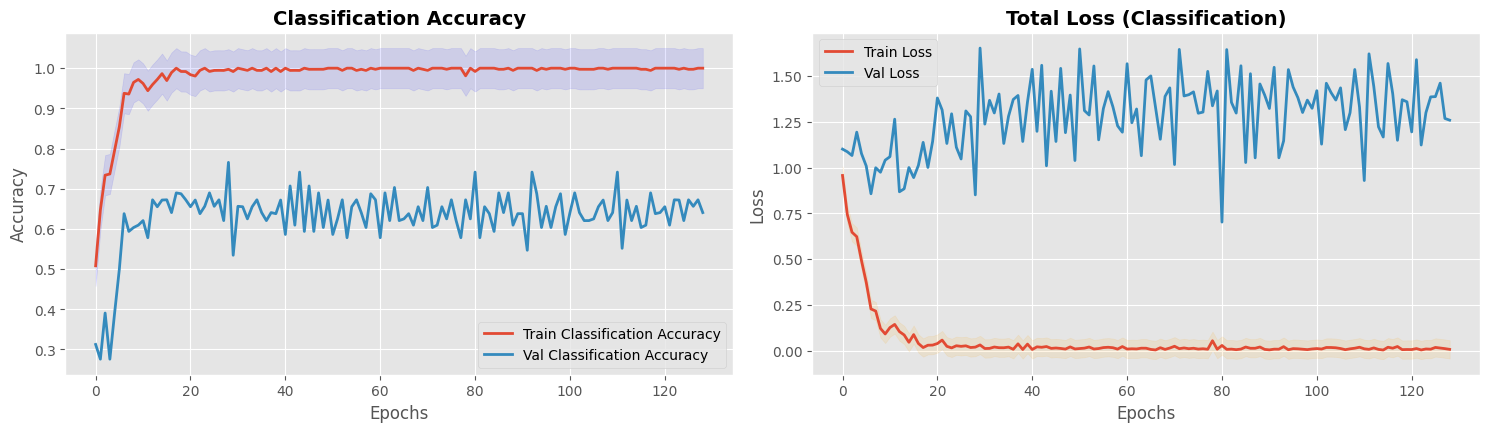

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 8))

plt.style.use('ggplot')

# Row 1: Classification metrics
plt.subplot(2, 2, 1)
plt.plot(history_classification.history['accuracy'], label='Train Classification Accuracy', linewidth=2)
plt.plot(history_classification.history['val_accuracy'], label='Val Classification Accuracy', linewidth=2)
plt.fill_between(range(len(history_classification.history['accuracy'])),
                 [a - 0.05 for a in history_classification.history['accuracy']],
                 [a + 0.05 for a in history_classification.history['accuracy']],
                 color='blue', alpha=0.1)
plt.title('Classification Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history_classification.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_classification.history['val_loss'], label='Val Loss', linewidth=2)
plt.fill_between(range(len(history_classification.history['loss'])),
                 [l - 0.05 for l in history_classification.history['loss']],
                 [l + 0.05 for l in history_classification.history['loss']],
                 color='orange', alpha=0.1)
plt.title('Total Loss (Classification)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()


Shape of y_true: (256,)
Shape of y_pred: (256, 3)


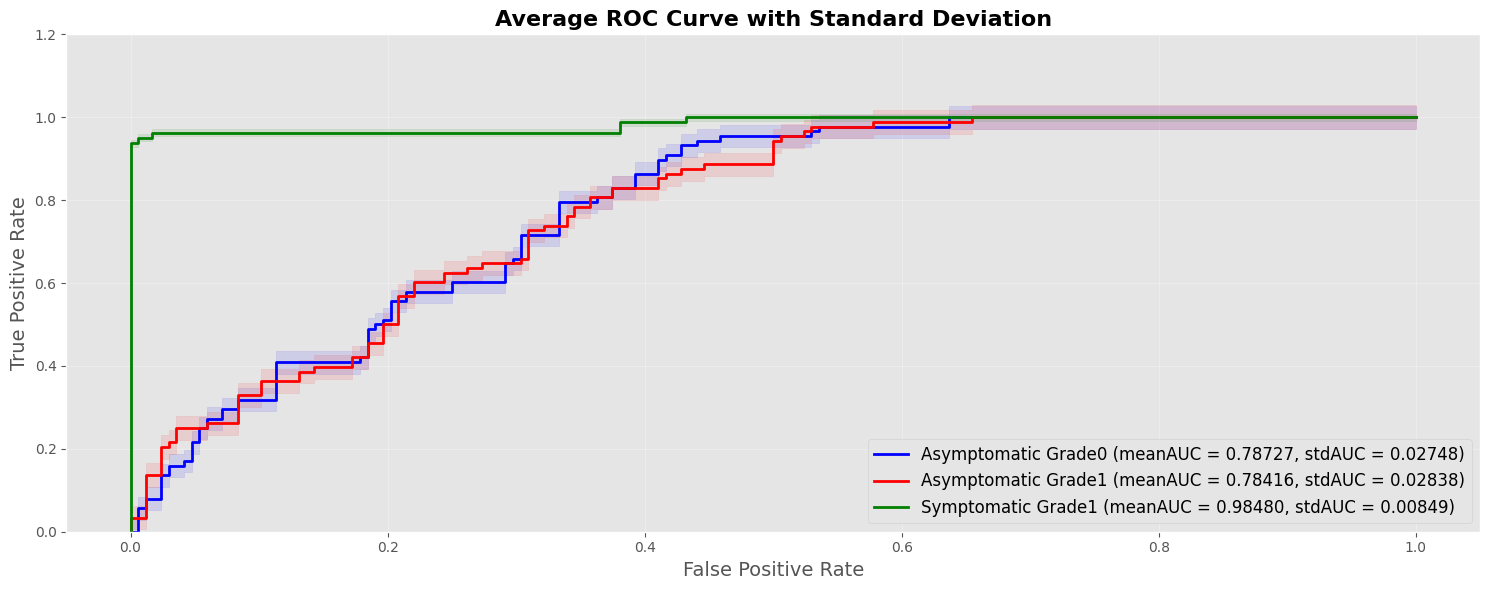

In [ ]:
# Collect true labels (y_true) and predictions (y_pred) from the generator
y_true = []
y_pred = []

for batch_images, batch_labels, _ in test_generator_classification:
    # Collect true labels
    y_true.extend(np.argmax(batch_labels, axis=1))
    # Collect model predictions
    y_pred.extend(model_classification.predict(batch_images, verbose=0))

    # Check the number of samples to avoid overloading
    if len(y_true) >= test_steps * batch_size:
        break

# Convert lists to numpy arrays
y_true = np.array(y_true[:test_steps * batch_size])  # Ensure sample count consistency
y_pred = np.array(y_pred[:test_steps * batch_size])

# Check the number of samples
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Convert y_true to one-hot format
y_true_one_hot = label_binarize(y_true, classes=[0, 1, 2])

# Number of bootstrap samples
n_bootstrap = 1000

# Create ROC curve for each class
plt.figure(figsize=(15, 6))
colors = ['blue', 'red', 'green']
labels = ['Asymptomatic Grade0', 'Asymptomatic Grade1', 'Symptomatic Grade1']

std_auc_per_class = []

for i in range(y_true_one_hot.shape[1]):
    # Calculate AUC
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    # Calculate stdAUC using Bootstrap
    aucs = []
    for _ in range(n_bootstrap):
        indices = resample(range(len(y_true)), replace=True)
        if len(set(y_true_one_hot[indices, i])) < 2:
            continue
        fpr_resampled, tpr_resampled, _ = roc_curve(y_true_one_hot[indices, i], y_pred[indices, i])
        aucs.append(auc(fpr_resampled, tpr_resampled))
    std_auc = np.std(aucs)
    std_auc_per_class.append(std_auc)

    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], label=f'{labels[i]} (meanAUC = {roc_auc:.5f}, stdAUC = {std_auc:.5f})', linewidth=2)

    # Plot shaded area (Confidence Interval)
    plt.fill_between(fpr, tpr - std_auc, tpr + std_auc, color=colors[i], alpha=0.1)

# Set plot appearance
plt.title('Average ROC Curve with Standard Deviation', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.2)
plt.tight_layout()
plt.show()


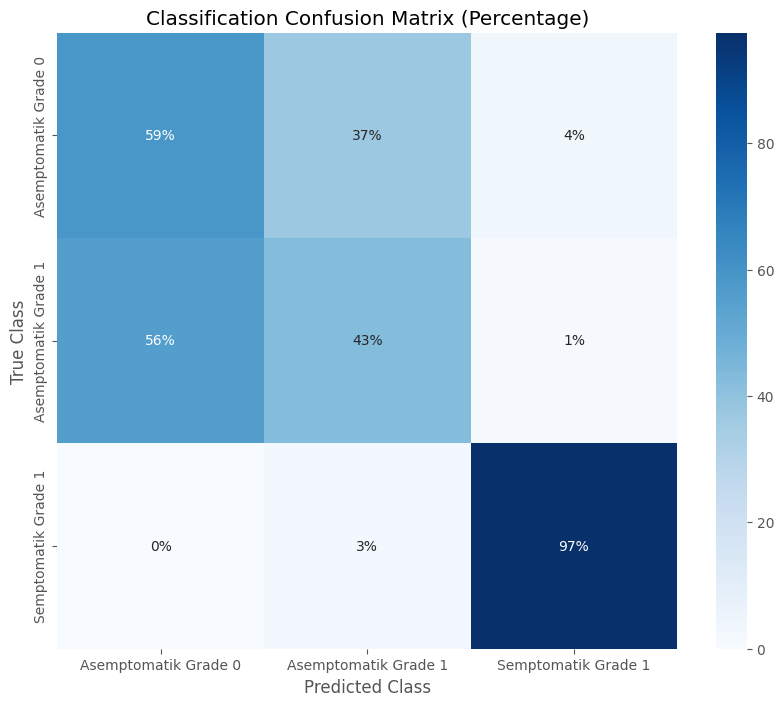

In [ ]:
# Extract all images and labels from the classification test generator
y_true_class = []
y_pred_class = []

test_steps_classification = 16

# Loop over the test dataset and collect true and predicted labels
for step in range(test_steps_classification):
    images, true_labels = next(test_generator_classification) # Converting one-hot to integer class labels
    # Get classification predictions
    predictions_class = model_classification.predict(images, verbose=0)

    # Append true labels and predicted labels
    y_true_class.extend(np.argmax(true_labels, axis=1))
    y_pred_class.extend(np.argmax(predictions_class, axis=1))

# Convert to NumPy arrays for confusion matrix calculation
y_true_class = np.array(y_true_class)
y_pred_class = np.array(y_pred_class)

# Generate the confusion matrix
cm_class = confusion_matrix(y_true_class, y_pred_class)

# Normalize the confusion matrix to show percentages
cm_percentage_class = cm_class.astype('float') / cm_class.sum(axis=1)[:, np.newaxis] * 100

# Define class labels (adjust according to your dataset)
class_names_class = ['Asemptomatik Grade 0', 'Asemptomatik Grade 1', 'Semptomatik Grade 1']

# Function to format annotations as percentages
def fmt_percent_class(value):
    return f'{value:.0f}%'

# Plot confusion matrix using Seaborn's heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage_class, annot=np.vectorize(fmt_percent_class)(cm_percentage_class), fmt='', cmap='Blues', xticklabels=class_names_class, yticklabels=class_names_class)
plt.title('Classification Confusion Matrix (Percentage)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, matthews_corrcoef

def classification_evaluation(test_generator_classification, model_classification, test_steps=8):
    # Initialize lists to store true and predicted labels
    y_true_class = []
    y_pred_class = []

    # Loop through test data and get true and predicted labels
    for step in range(test_steps):
        images, true_labels = next(test_generator_classification)

        if len(true_labels.shape) > 1:  # Check if labels are one-hot encoded
            true_labels = np.argmax(true_labels, axis=1)

        # Add true labels to y_true_class list
        y_true_class.extend(true_labels)

        # Get predicted class labels from the model
        predictions = model_classification.predict(images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        y_pred_class.extend(predicted_classes)

    # Convert to NumPy arrays
    y_true_class = np.array(y_true_class)
    y_pred_class = np.array(y_pred_class)

    # Define class names
    class_names = ['Asemptomatik Grade 0', 'Asemptomatik Grade 1', 'Semptomatik Grade 1']

    # Generate classification report
    print(classification_report(y_true_class, y_pred_class, target_names=class_names))

    # Calculate MCC
    mcc = matthews_corrcoef(y_true_class, y_pred_class)
    print(f"\nMatthews Correlation Coefficient (MCC): {mcc:.5f}")

# Call the function for classification evaluation
classification_evaluation(test_generator_classification, model_classification)


                      precision    recall  f1-score   support

Asemptomatik Grade 0       0.50      0.65      0.56        37
Asemptomatik Grade 1       0.63      0.49      0.55        49
 Semptomatik Grade 1       0.95      0.95      0.95        42

            accuracy                           0.69       128
           macro avg       0.69      0.70      0.69       128
        weighted avg       0.70      0.69      0.69       128


Matthews Correlation Coefficient (MCC): 0.53973


In [ ]:

class_names = ['Asemptomatik Grade 0', 'Asemptomatik Grade 1', 'Semptomatik Grade 1']
# Compute the confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)

# Calculate accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)  # True Positives / Total samples of each class

# Print accuracy for each class
for idx, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {class_names[idx]}: {accuracy:.2f}")

# Calculate specificity for each class
class_specificities = []
for i in range(len(cm)):
    # True Negatives (sum of all elements except row i and column i)
    TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    # False Positives (sum of column i except diagonal)
    FP = cm[:, i].sum() - cm[i, i]
    # Specificity formula: TN / (TN + FP)
    specificity = TN / (TN + FP)
    class_specificities.append(specificity)

# Print specificity for each class
for idx, specificity in enumerate(class_specificities):
    print(f"Specificity for class {class_names[idx]}: {specificity:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


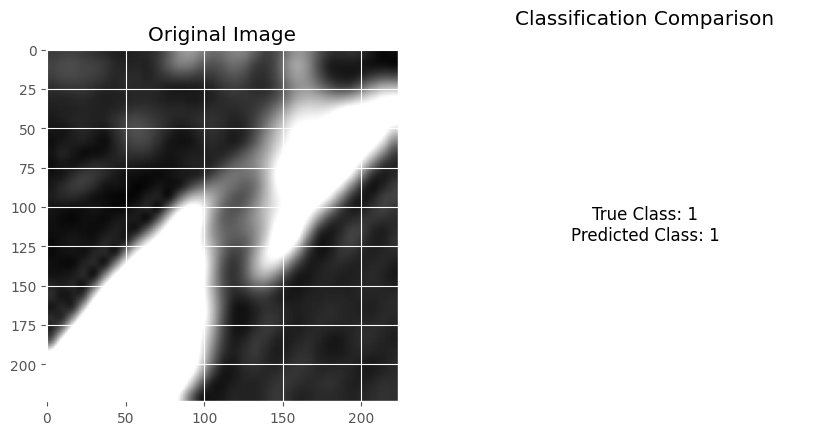

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


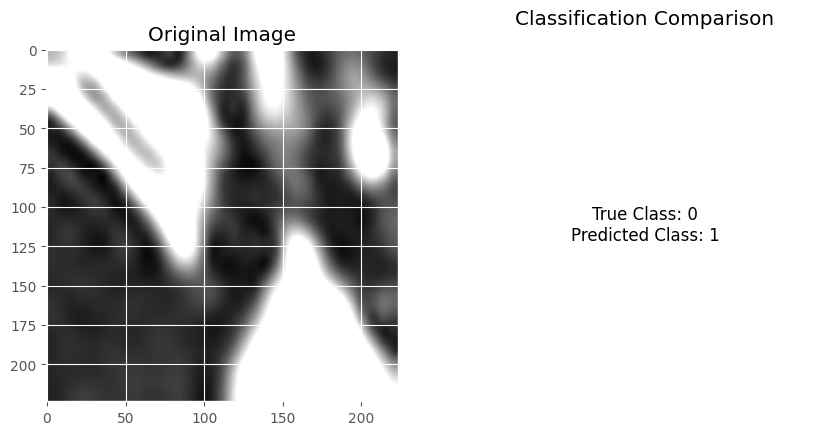

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


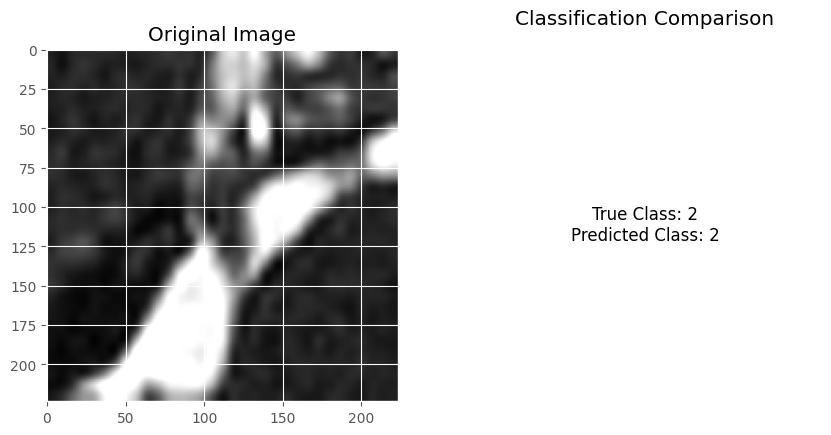

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


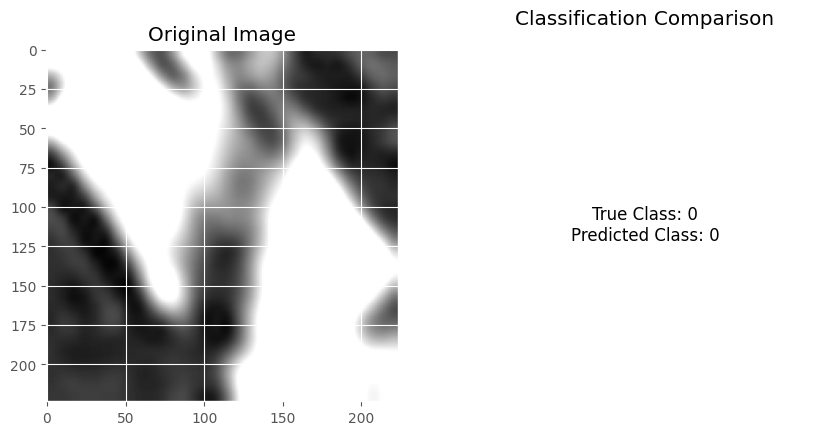

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


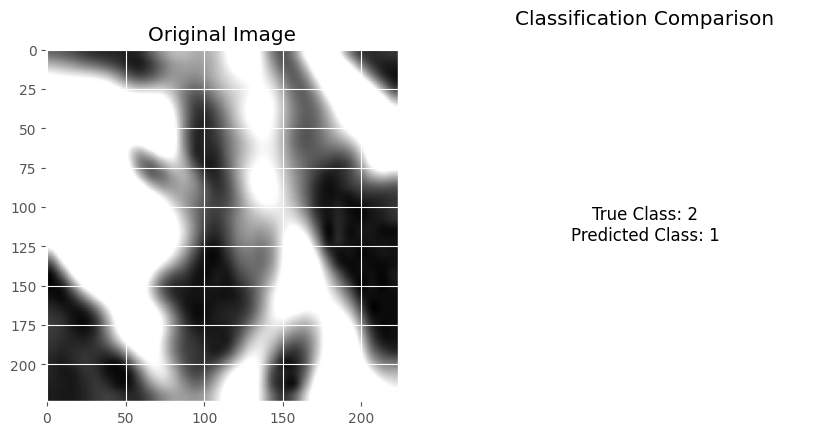

In [ ]:
def display_sample_predictions_classification(generator, num_samples=5, model_classification=None):
    for i in range(num_samples):
        # Get a batch of images and their corresponding labels
        #img_batch, class_labels, _ = next(generator)
        img_batch, class_labels = next(generator)  # Removed the third element (class weights)

        # Make classification predictions
        predicted_classes = np.argmax(model_classification.predict(img_batch), axis=1)

        plt.figure(figsize=(10, 5))

        # Display original image
        plt.subplot(1, 2, 1)
        plt.imshow(img_batch[0].squeeze(), cmap='gray')
        plt.title('Original Image')

        # Display classification comparison
        plt.subplot(1, 2, 2)
        # Convert true label from one-hot encoding to integer label if necessary
        true_class = np.argmax(class_labels[0]) if len(class_labels[0].shape) > 0 else class_labels[0]
        plt.text(0.5, 0.5, f'True Class: {true_class}\nPredicted Class: {predicted_classes[0]}',
                 horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.title('Classification Comparison')
        plt.axis('off')

        plt.show()

# Call the function to display sample predictions for classification
display_sample_predictions_classification(test_generator_classification, model_classification=model_classification)
